In [1]:
import torch
import torch.nn.functional as F
from datasets import *
from torchvision import transforms
from torch.utils.data import DataLoader
from models.ddpm_scheduler import NoiseScheduler
from models.ddpm import *
from models.embedding import * 
from models.mlp import *

In [55]:
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 10)
x = np.stack((x, x), axis=1)
x = (x - 5) / 5
print(x)
x = x * 5 + 5
print(x)

[[-1.         -1.        ]
 [-0.77777778 -0.77777778]
 [-0.55555556 -0.55555556]
 [-0.33333333 -0.33333333]
 [-0.11111111 -0.11111111]
 [ 0.11111111  0.11111111]
 [ 0.33333333  0.33333333]
 [ 0.55555556  0.55555556]
 [ 0.77777778  0.77777778]
 [ 1.          1.        ]]
[[ 0.          0.        ]
 [ 1.11111111  1.11111111]
 [ 2.22222222  2.22222222]
 [ 3.33333333  3.33333333]
 [ 4.44444444  4.44444444]
 [ 5.55555556  5.55555556]
 [ 6.66666667  6.66666667]
 [ 7.77777778  7.77777778]
 [ 8.88888889  8.88888889]
 [10.         10.        ]]


In [44]:
np.linspace?

Signature:
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Docstring:
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

.. versionchanged:: 1.20.0
    Values are rounded towards ``-inf`` instead of ``0`` when an
    integer ``dtype`` is specified. The old behavior can
    still be obtained with ``np.linspace(start, stop, num).astype(int)``

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The end value of the sequence, unless `endpoint` is set to False.
    In that case, the sequence consists of all but the last of ``num + 1``
    evenly spaced samples, so that `stop` is excluded.  Note that the step
    size changes when `endpoint` is Fals

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

atr_embedding = LabelEmbedding(num_classes=5, hidden_size=10, dropout_prob=0.1).to(device)
obj_embedding = LabelEmbedding(num_classes=5, hidden_size=10, dropout_prob=0.1).to(device)
time_embedding = SinusoidalEmbedding(size=10)
nn_model = MLP(
    hidden_layers=3,
    input_size=2,
    emb_size=10,
    hidden_size=32,
).to(device)

ns = NoiseScheduler(50)

params = list(atr_embedding.parameters()) + list(obj_embedding.parameters()) + list(nn_model.parameters())
optimizer = torch.optim.AdamW(params, lr=0.1)

x = torch.FloatTensor([[0.9, 0.9]]).to(device)
c = torch.LongTensor([[0,1]]).to(device)
noise = torch.randn(x.size())
timesteps = torch.randint(0, 50, (1,))

c1, c2 = c[:, 0], c[:, 1]
c1 = obj_embedding(c1)
c2 = atr_embedding(c2)
t = time_embedding(timesteps)
x_t = ns.add_noise(x.cpu(), noise, timesteps)

x_t = x_t.to(device)
t = t.to(device)
noise = noise.to(device)
noise_pred = nn_model(x_t, c1, c2, t)
loss = F.mse_loss(noise_pred, noise)
loss.backward()

tensor(0.9265, device='cuda:0', grad_fn=<MseLossBackward0>)

In [31]:
from tqdm.auto import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples=25
x_i = torch.randn(n_samples, 2).to(device)

# timesteps list
timesteps = list(range(50))[::-1]

# create conditions of each class
c1 = torch.arange(0, 5)
c2 = torch.arange(0, 5)
c1 = c1.repeat(5)
c2 = c2.repeat(5)

c1, c2 = c1.to(device), c2.to(device)

# conditional embedding
c1 = obj_embedding(c1)
c2 = atr_embedding(c2)

# unconditional embedding, create zero embedding vector
c1_unc = torch.zeros(c1.size(), device=device)
c2_unc = torch.zeros(c2.size(), device=device)

for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, n_samples))
    t_emb = time_embedding(t).to(device)
#     t_emb = t_emb.to(device)
    with torch.no_grad():
        cond_pred = nn_model(x_i, c1, c2, t_emb)
        uncond_pred = nn_model(x_i, c1_unc, c2_unc, t_emb)

        # classifier-free guidance
        eps = (1 + 0.1) * cond_pred - 0.1 * uncond_pred

        x_i = ns.step(eps.cpu(), t[0], x_i.cpu()).to(device)
x_i.size()


100%|██████████| 50/50 [00:00<00:00, 985.94it/s]


torch.Size([25, 2])

In [18]:
timesteps = list(range(50))[::-1]
t = timesteps[0]
t = torch.from_numpy(np.repeat(t, 25))

array([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49])

In [20]:
torch.from_numpy?

Docstring:
from_numpy(ndarray) -> Tensor

Creates a :class:`Tensor` from a :class:`numpy.ndarray`.

The returned tensor and :attr:`ndarray` share the same memory. Modifications to
the tensor will be reflected in the :attr:`ndarray` and vice versa. The returned
tensor is not resizable.

It currently accepts :attr:`ndarray` with dtypes of ``numpy.float64``,
``numpy.float32``, ``numpy.float16``, ``numpy.complex64``, ``numpy.complex128``,
``numpy.int64``, ``numpy.int32``, ``numpy.int16``, ``numpy.int8``, ``numpy.uint8``,
and ``numpy.bool``.

.. warning::
    Writing to a tensor created from a read-only NumPy array is not supported and will result in undefined behavior.

Example::

    >>> a = numpy.array([1, 2, 3])
    >>> t = torch.from_numpy(a)
    >>> t
    tensor([ 1,  2,  3])
    >>> t[0] = -1
    >>> a
    array([-1,  2,  3])
Type:      builtin_function_or_method

In [6]:
x = torch.randn(1, 2).to(device)
c1 = torch.Tensor([1]).to(device).type(torch.LongTensor).to(device)
c2 = torch.Tensor([1]).to(device).type(torch.LongTensor).to(device)
c = torch.stack((c1, c2), axis=1)
loss = ddpm(x, c)
loss.item()

torch.Size([1, 2]) torch.Size([1, 10]) torch.Size([1, 10]) torch.Size([1, 10])


0.03332122415304184

In [20]:
ea = a_emb(c1)
eo = o_emb(c2)
_t = torch.randint(1, 51, (1,)).to(device)
t = t_emb(_t / 50)
torch.cat((x, ea, eo, t), axis=-1)

tensor([[-0.6172, -1.2266,  0.3529, -0.3628, -0.5103, -1.1034,     nan,     nan]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [10]:
x = torch.randn(25, 2)
c1 = torch.arange(0, 5).view(-1, 1)
c2 = torch.arange(0, 5)
c2 = c2.repeat(5)
c1 = c1.repeat(1, 5)
c1 = c1.view(-1)
c = torch.stack((c1, c2), axis=1)
c.size()

torch.Size([25, 2])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_samples = 100
radius = 1

def generate_circle(center, radius, num_samples):
    theta = np.linspace(0, 2*np.pi, num_samples)
    centerX, centerY = center
    a, b = radius * np.cos(theta) + centerX, radius * np.sin(theta) + centerY

    r = np.random.rand((num_samples)) * radius
    x, y = r * np.cos(theta) + centerX, r * np.sin(theta) + centerY
    return np.stack((x, y), axis=1)


p = generate_circle((1,1), 0.1, 100)

# plt.figure(figsize=(7,6))
# plt.plot(a, b, linestyle='-', linewidth=2, label='Circle')
# plt.plot(x, y, marker='.', linestyle="", label='Samples')
# plt.ylim([-(radius + 1), radius + 1])
# plt.xlim([-(radius + 1), radius + 1])
# plt.grid()
# plt.legend(loc='upper right')
# plt.show(block=True)

# Generate point dataset

In [63]:
import os
save_root = 'data/2DPoints'
dirs = os.listdir(save_root)
radius = 0.1
num_samples = 100
a = []

for i in range(1, 6):
    tmp = [i - 0.1] * 5
    a.extend(tmp)
b = list(map(lambda x: x - 0.1, range(1, 6))) * 5
centers = list(zip(a,b))

for center, d in zip(centers, dirs):
    p = generate_circle(center, radius, num_samples)
    d = f'A{int(center[0]+0.1)} B{int(center[1]+0.1)}'
    np.save(os.path.join(save_root, d, 'points.npy'), p)

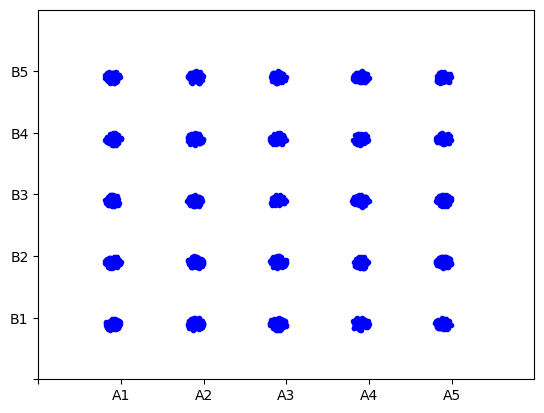

In [79]:
from glob import glob
npys = glob(os.path.join(save_root, '**', '*npy'))
p = np.load('data/2DPoints/A1 B1/points.npy')
plt.xticks(np.arange(0,6), ['', 'A1', 'A2', 'A3', 'A4', 'A5'])
plt.yticks(np.arange(0,6), ['', 'B1', 'B2', 'B3', 'B4', 'B5'])
plt.xlim([0, 6])
plt.ylim([0, 6])

for npy in npys:
    p = np.load(npy)
    plt.plot(p[:, 0], p[:, 1], marker='.', color='blue', linestyle="")